***

# The Title: "Analyzing the market for a taxi company"

## Project Description
A new ride-sharing company  is being launched. 
The task is:
1. Find patterns in the available information
- Understand passenger preferences and the impact of external factors on rides.
- Analyze data about competitors
- Check the impact of weather on ride frequency.

### Description of the data:
#### `project_sql_result_01.csv`
* *company_name*: taxi company name
* *trips_amount*: the number of rides for each taxi company on November 15-16, 2017.

#### `project_sql_result_04.csv`
* *dropoff_location_name*: neighborhoods where rides ended
* *average_trips*: the average number of rides that ended in each neighborhood in November 2017.

#### `project_sql_result_07.csv`
* *start_ts*: pickup date and time
* *weather_conditions*: weather conditions at the moment the ride started
* *duration_seconds*: ride duration in seconds

***

### Processing

In [1]:
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import squarify

%matplotlib inline

sns.set_style('darkgrid')

from scipy import stats as st

In [2]:
path = '/datasets/'
companies = pd.read_csv(path+'project_sql_result_01.csv', sep=',' )
locations = pd.read_csv(path+'project_sql_result_04.csv', sep=',' )
weather = pd.read_csv(path+'project_sql_result_07.csv', sep=',')

In [3]:
companies.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [4]:
locations.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [5]:
weather.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [6]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
company_name    64 non-null object
trips_amount    64 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [7]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
dropoff_location_name    94 non-null object
average_trips            94 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
start_ts              1068 non-null object
weather_conditions    1068 non-null object
duration_seconds      1068 non-null float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


I'll round up duration everywhere

In [9]:
locations['average_trips'] = locations['average_trips'].astype(int)

In [10]:
weather['duration_seconds'] = weather['duration_seconds'].astype(int)

Convert to timestamp

In [11]:
weather['start_ts']= pd.to_datetime(weather['start_ts'], format='%Y-%m-%dT%H:%M:%S')

In [12]:
weather.describe()

,duration_seconds
count,1068.000000
mean,2071.731273
std,769.461125
min,0.000000
25%,1438.250000
50%,1980.000000
75%,2580.000000
max,7440.000000


In [13]:
weather[weather['duration_seconds']==0]

,start_ts,weather_conditions,duration_seconds
163,2017-11-11 09:00:00,Good,0
168,2017-11-11 07:00:00,Good,0
204,2017-11-18 19:00:00,Good,0
552,2017-11-04 01:00:00,Good,0
801,2017-11-04 09:00:00,Good,0
1063,2017-11-25 11:00:00,Good,0


We have duration = 0, I supposed that it is mistaken data, the amount is pity and I'll delete these rows

In [14]:
weather = weather[weather['duration_seconds']!=0]

### Calculations

### Top10 dropoff locations

In [15]:
locations.sort_values(by = 'average_trips',ascending=False).head(10)

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9523
2,Streeterville,6664
3,West Loop,5163
4,O'Hare,2546
5,Lake View,2420
6,Grant Park,2068
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1259


In [16]:
top_dropoff = locations.sort_values(by = 'average_trips',ascending=False).head(10)

Text(0.5, 1.0, 'Amount of trips by top10 dropoff location')

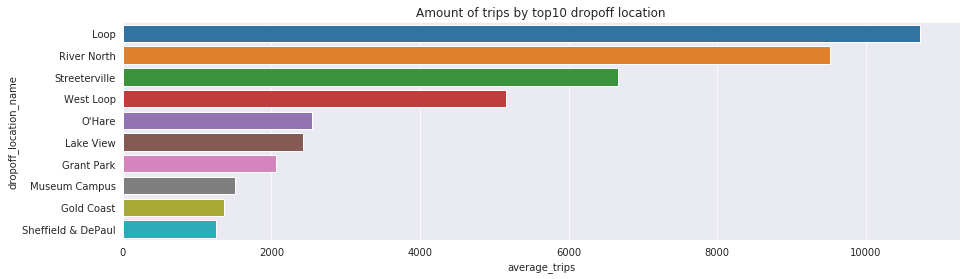

In [17]:
plt.figure(figsize=(15,4))
sns.barplot(data = top_dropoff, y='dropoff_location_name', x = 'average_trips')
plt.title('Amount of trips by top10 dropoff location')

A pair of dropoff leaders, a pair after them and all the rest

In [18]:
str(top_dropoff['dropoff_location_name'][:2].to_list())[1:-1]

"'Loop', 'River North'"

In [19]:
str(top_dropoff['dropoff_location_name'][2:4].to_list())[1:-1]

"'Streeterville', 'West Loop'"

'Loop', 'River North' are leaders by amount of trips

After them are 'Streeterville', 'West Loop'

In [20]:
dropoff=locations.copy()

In [21]:
dropoff['dropoff_location_name'] = dropoff['dropoff_location_name'].where(dropoff['dropoff_location_name'].isin(top_dropoff['dropoff_location_name']),'Others')

In [22]:
dropoff.pivot_table(index='dropoff_location_name', values ='average_trips', aggfunc='sum')

,average_trips
dropoff_location_name,
Gold Coast,1364
Grant Park,2068
Lake View,2420
Loop,10727
Museum Campus,1510
O'Hare,2546
Others,13107
River North,9523
Sheffield & DePaul,1259


In [23]:
dropoff = dropoff.pivot_table(index='dropoff_location_name', values ='average_trips', aggfunc='sum')

In [24]:
dropoff = dropoff.reset_index()

In [25]:
dropoff['location_share'] = dropoff['average_trips']/dropoff['average_trips'].sum()

In [26]:
dropoff = dropoff.sort_values(by = 'average_trips', ascending=False )

In [27]:
dropoff = dropoff.reset_index(drop=True)

In [28]:
dropoff

,dropoff_location_name,average_trips,location_share
0,Others,13107,0.232596
1,Loop,10727,0.190360
2,River North,9523,0.168994
3,Streeterville,6664,0.118259
4,West Loop,5163,0.091622
5,O'Hare,2546,0.045181
6,Lake View,2420,0.042945
7,Grant Park,2068,0.036699
8,Museum Campus,1510,0.026796
9,Gold Coast,1364,0.024205


Matplotlib calculates share automatically, but for better visibility I've add it to the table

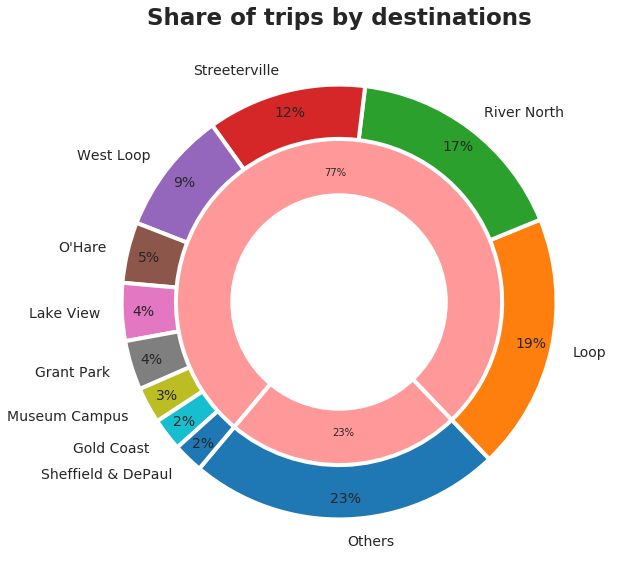

In [29]:
plt.figure(figsize=(10,10))

startangel = -130

# Data to plot
#outer
labels = dropoff['dropoff_location_name']
sizes = dropoff['average_trips']

# inner
labels_inner = ['Other', 'Top10']
sizes_inner = [dropoff['average_trips'][0],dropoff['average_trips'][1:].sum()]


colors_inner = ['#ff9999','#ff9999']
 
# Plot outer
plt.pie(sizes, labels=labels
        #, colors=colors
        , startangle=startangel
        ,frame=True
                , autopct='%1.0f%%'
        ,pctdistance=0.9
                ,textprops={'fontsize': 14}
 
       ,wedgeprops = {'linewidth': 4}
       )

# Plot inner
plt.pie(sizes_inner
        ,colors=colors_inner
        ,radius=0.75
        ,startangle=startangel
        , autopct='%1.0f%%'
        ,pctdistance=0.8
        ,wedgeprops = {'linewidth': 4}
       )



centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)

fig = plt.gcf()
fig.gca().add_artist(centre_circle)



plt.title('Share of trips by destinations',fontsize=23,fontweight="bold")
plt.show()

We can see, that top10 dropoff destinations is about 77% of the market

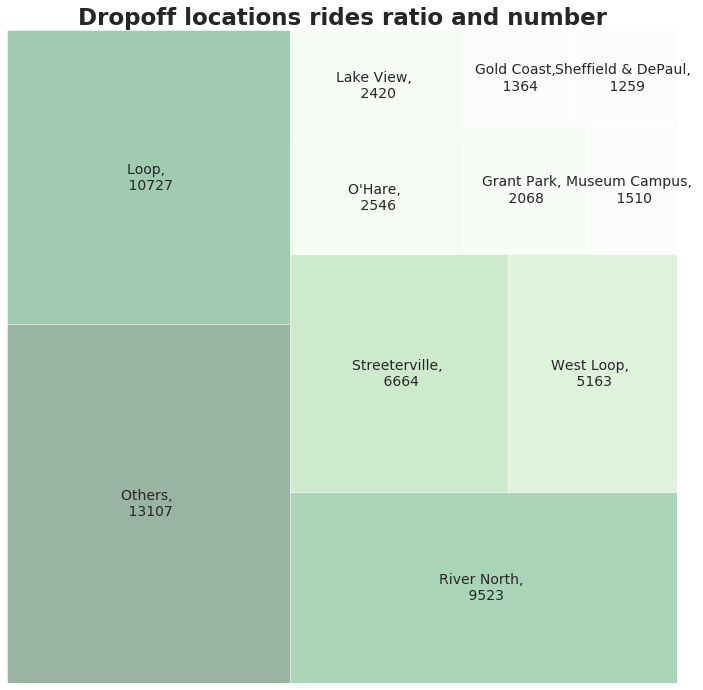

In [30]:
plt.figure(figsize=(12,12))


labels = dropoff['dropoff_location_name']
sizes = dropoff['average_trips']


lbl = [i+', \n '+str(j) for i,j in zip(labels, sizes)]

cmap = matplotlib.cm.Greens
mini=min(sizes)
maxi=max(sizes)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)

colors = [cmap(norm(value)) for value in sizes]


squarify.plot(sizes=sizes, label=lbl, alpha=0.4,color=colors, text_kwargs={'fontsize':14}
             # , pad=True
             )
plt.axis('off')

plt.title('Dropoff locations rides ratio and number',fontsize=23,fontweight="bold")
plt.show()

### Top10 Companies

In [31]:
companies['trips_amount'].sum()

137311

In [32]:
top_companies = companies.sort_values(by = 'trips_amount',ascending=False).head(10)

In [33]:
top_companies['company_name'].to_list()

['Flash Cab',
 'Taxi Affiliation Services',
 'Medallion Leasing',
 'Yellow Cab',
 'Taxi Affiliation Service Yellow',
 'Chicago Carriage Cab Corp',
 'City Service',
 'Sun Taxi',
 'Star North Management LLC',
 'Blue Ribbon Taxi Association Inc.']

In [34]:
top_companies

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


Text(0.5, 1.0, 'Top10 companies by amount of trips')

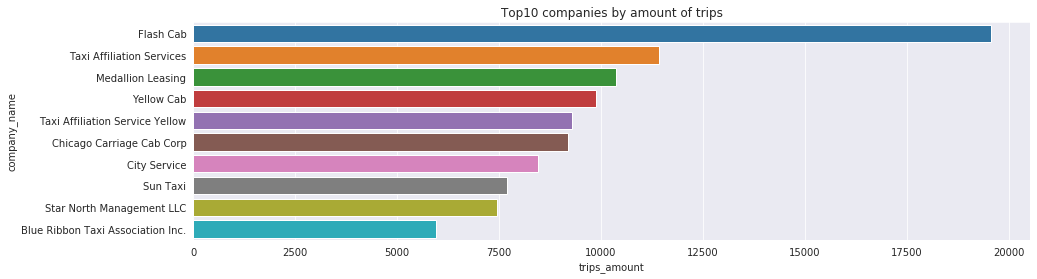

In [35]:
plt.figure(figsize=(15,4))

sns.barplot(data = top_companies, y='company_name', x = 'trips_amount')

plt.title('Top10 companies by amount of trips')

One leader and all the rest

In [36]:
top_companies.head(1).values[0][0]

'Flash Cab'

Flash Cab is the leader and make about twice more trips than it closest opponent

In [37]:
companies_short=companies.copy()

In [38]:
companies_short['company_name'] = companies_short['company_name'].where(companies_short['company_name'].isin(top_companies['company_name']),'Others')

In [39]:
companies_short.pivot_table(index='company_name', values ='trips_amount', aggfunc='sum')

,trips_amount
company_name,
Blue Ribbon Taxi Association Inc.,5953
Chicago Carriage Cab Corp,9181
City Service,8448
Flash Cab,19558
Medallion Leasing,10367
Others,38039
Star North Management LLC,7455
Sun Taxi,7701
Taxi Affiliation Service Yellow,9299


In [40]:
companies_short = companies_short.pivot_table(index='company_name', values ='trips_amount', aggfunc='sum')

In [41]:
companies_short = companies_short.reset_index()

In [42]:
companies_short['rides_share'] = companies_short['trips_amount']/companies_short['trips_amount'].sum()

In [43]:
companies_short = companies_short.sort_values(by = 'trips_amount', ascending=False )

In [44]:
companies_short = companies_short.reset_index(drop=True)

In [45]:
companies_short

,company_name,trips_amount,rides_share
0,Others,38039,0.277028
1,Flash Cab,19558,0.142436
2,Taxi Affiliation Services,11422,0.083183
3,Medallion Leasing,10367,0.075500
4,Yellow Cab,9888,0.072012
5,Taxi Affiliation Service Yellow,9299,0.067722
6,Chicago Carriage Cab Corp,9181,0.066863
7,City Service,8448,0.061525
8,Sun Taxi,7701,0.056084
9,Star North Management LLC,7455,0.054293


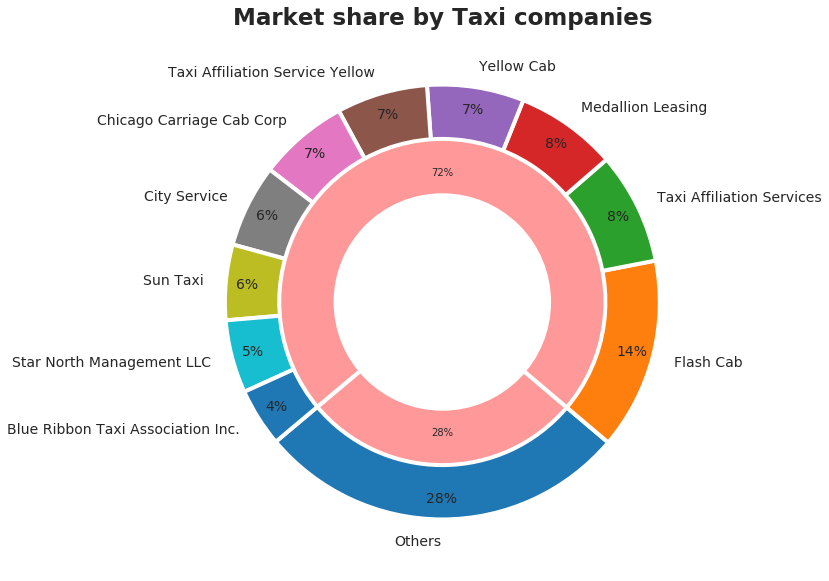

In [46]:
plt.figure(figsize=(10,10))

startangel = -140

# Data to plot
#outer
labels = companies_short['company_name']
sizes = companies_short['trips_amount']

# inner
labels_inner = ['', 'Top10']
sizes_inner = [companies_short['trips_amount'][0],companies_short['trips_amount'][1:].sum()]


colors_inner = ['#ff9999','#ff9999']
 
# Plot outer
plt.pie(sizes, labels=labels
        #, colors=colors
        , startangle=startangel
        ,frame=True
                , autopct='%1.0f%%'
        ,pctdistance=0.9
                ,textprops={'fontsize': 14}
 
       ,wedgeprops = {'linewidth': 4}
       )

# Plot inner
plt.pie(sizes_inner
        #, labels=labels_inner
        ,colors=colors_inner
        ,radius=0.75
        ,startangle=startangel
        , autopct='%1.0f%%'
        ,pctdistance=0.8
        #,labeldistance =0.6
        ,wedgeprops = {'linewidth': 4}
       )


#plt.legend(loc="best")
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)

fig = plt.gcf()
fig.gca().add_artist(centre_circle)



plt.title('Market share by Taxi companies',fontsize=23,fontweight="bold")
plt.show()

We can see, that Top10 companies hold 72% of the market

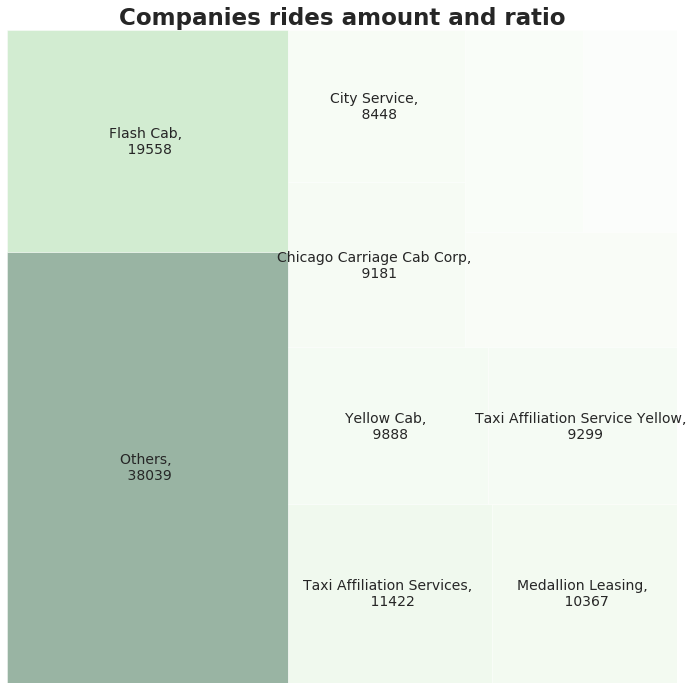

In [47]:
plt.figure(figsize=(12,12))


labels = companies_short['company_name'][:8]
sizes = companies_short['trips_amount']


lbl = [i+', \n '+str(j) for i,j in zip(labels, sizes)]

cmap = matplotlib.cm.Greens
mini=min(sizes)
maxi=max(sizes)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)

colors = [cmap(norm(value)) for value in sizes]


squarify.plot(sizes=sizes, label=lbl, alpha=0.4,color=colors, text_kwargs={'fontsize':14}
             # , pad=True
             )
plt.axis('off')

plt.title('Companies rides amount and ratio',fontsize=23,fontweight="bold")
plt.show()

### Weather

In [48]:
weather.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410
1,2017-11-25 14:00:00,Good,1920
2,2017-11-25 12:00:00,Good,1543
3,2017-11-04 10:00:00,Good,2512
4,2017-11-11 07:00:00,Good,1440


In [49]:
weather['weather_conditions'].value_counts(dropna=True, normalize=True)

Good    0.830508
Bad     0.169492
Name: weather_conditions, dtype: float64

Proportion of days with good weather is very high about 83% of the period.

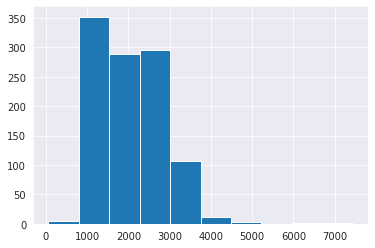

In [50]:
weather['duration_seconds'].hist()

I convert seconds to minutues for better comprehension

In [51]:
weather['duration_minutes'] = weather['duration_seconds']/60

In [52]:
weather['duration_minutes'] = weather['duration_minutes'].astype(int)

Text(0.5, 1.0, 'Distibution of trips duration')

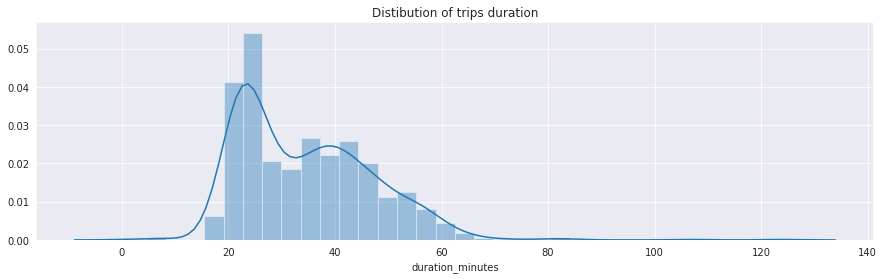

In [53]:
plt.figure(figsize=(15,4))

sns.distplot(weather['duration_minutes'])

plt.title('Distibution of trips duration')

We have distribution of duration with few picks

We are working with the same weekday around the period, hence I'll keep only the hour of the trip as the factor for investigation

In [54]:
weather['start_ts'].dt.hour

0       16
1       14
2       12
3       10
4        7
        ..
1062     6
1064    10
1065    13
1066     8
1067    16
Name: start_ts, Length: 1062, dtype: int64

In [55]:
weather['start_hour'] = weather['start_ts'].dt.hour

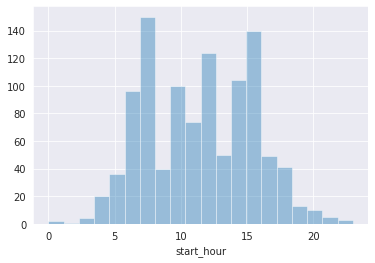

In [56]:
sns.distplot(weather['start_hour'], kde=False)

In [57]:
df = weather[['duration_minutes','start_hour', 'weather_conditions']].copy()

The main issue is to investigate the influence of the weather, so I'll provide further comparasion by Good / Bad weather factor

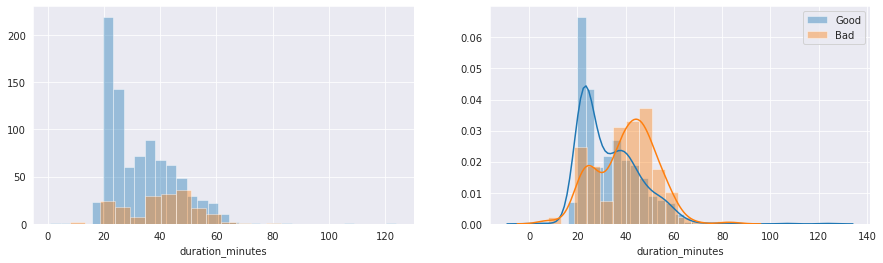

In [58]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
sns.distplot(df[df['weather_conditions']=='Good']['duration_minutes'],kde=False)
sns.distplot(df[df['weather_conditions']=='Bad']['duration_minutes'],kde=False)

plt.subplot(1, 2, 2)
sns.distplot(df[df['weather_conditions']=='Good']['duration_minutes']
             #,kde=False
            )
sns.distplot(df[df['weather_conditions']=='Bad']['duration_minutes']
            # ,kde=False
            )

plt.legend(labels=['Good','Bad'])

plt.show()

We can clearly see, that for Good weather we have more short trips and for Bad weather we have less trips in general.

In [59]:
df.corr()

,duration_minutes,start_hour
duration_minutes,1.000000,0.597363
start_hour,0.597363,1.000000


In [60]:
conditions = df['weather_conditions'].unique().tolist()
conditions

['Good', 'Bad']

In [61]:
for i in conditions:
    print(i)
    print(df.query('weather_conditions==@i').corr())
    print()

Good
                  duration_minutes  start_hour
duration_minutes          1.000000    0.582328
start_hour                0.582328    1.000000

Bad
                  duration_minutes  start_hour
duration_minutes          1.000000    0.548398
start_hour                0.548398    1.000000



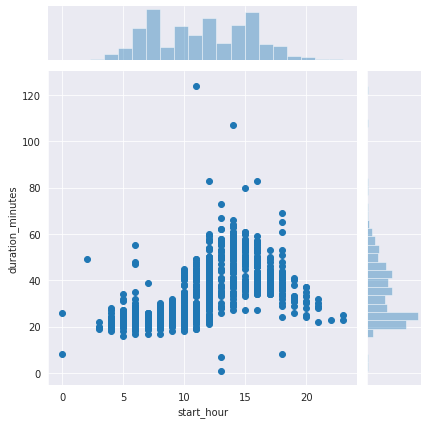

In [62]:
sns.jointplot(x='start_hour',y='duration_minutes',data=df
              ,kind='scatter')

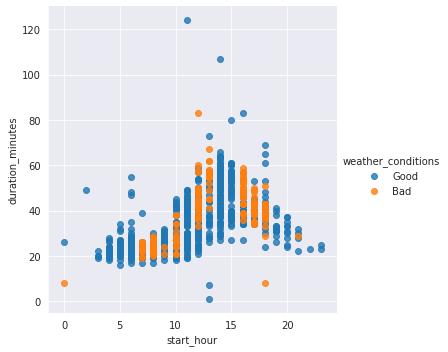

In [63]:
sns.lmplot(x='start_hour',y='duration_minutes',data=df, hue='weather_conditions'  , fit_reg=False)
plt.show()

We can see, that duration of the trip has medium correlation with the hour, when it happens

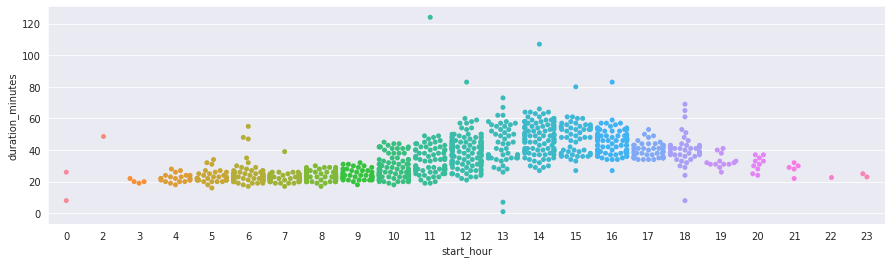

In [64]:
plt.figure(figsize=(15,4))
sns.swarmplot(x='start_hour',y='duration_minutes',data=df
                          )

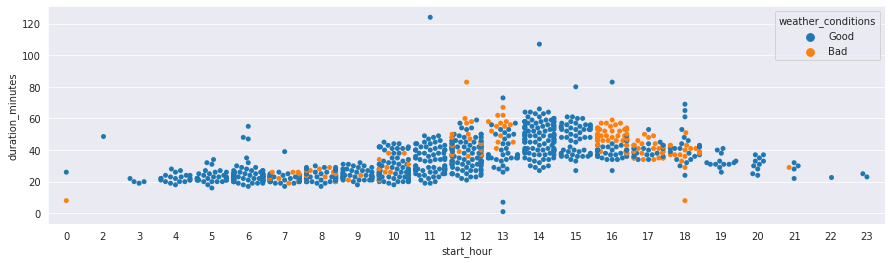

In [65]:
plt.figure(figsize=(15,4))
sns.swarmplot(x='start_hour',y='duration_minutes',data=df, hue='weather_conditions'
                          )

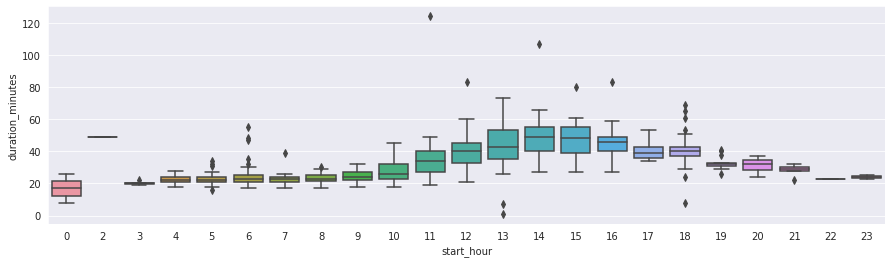

In [66]:
plt.figure(figsize=(15,4))
sns.boxplot(x='start_hour',y='duration_minutes',data=df
                          )

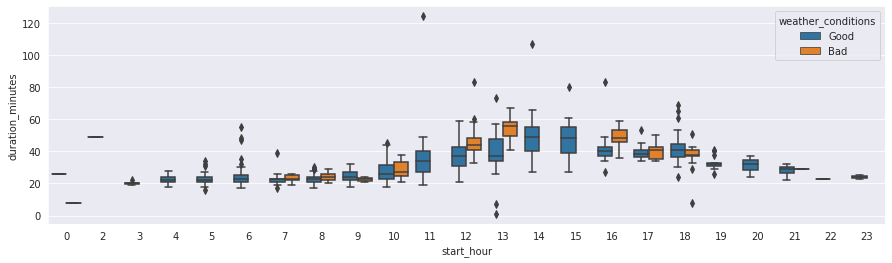

In [67]:
plt.figure(figsize=(15,4))
sns.boxplot(x='start_hour',y='duration_minutes',data=df, hue='weather_conditions'
           # , palette="Set4"
                          )

Text(0.5, 1.0, 'Average trip time')

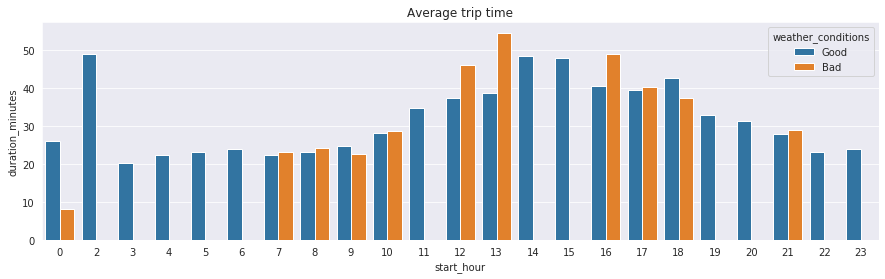

In [68]:
plt.figure(figsize=(15,4))
sns.barplot(x='start_hour',y='duration_minutes',data=df, hue='weather_conditions'
            ,ci=False)
plt.title("Average trip time")

Text(0.5, 1.0, 'Longets trips')

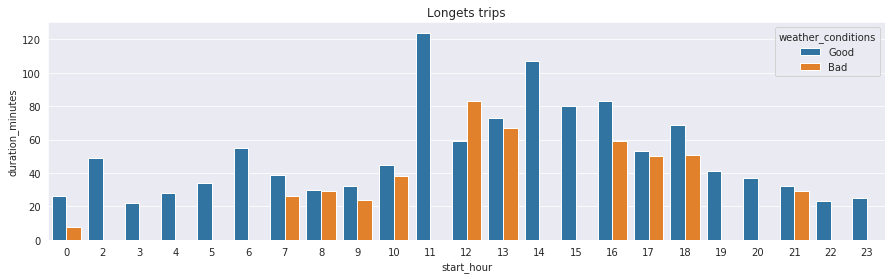

In [69]:
plt.figure(figsize=(15,4))
sns.barplot(x='start_hour',y='duration_minutes',data=df, hue='weather_conditions'
            ,ci=False
           ,estimator = np.max               
           )

plt.title('Longets trips')

Text(0.5, 1.0, 'Trip time std')

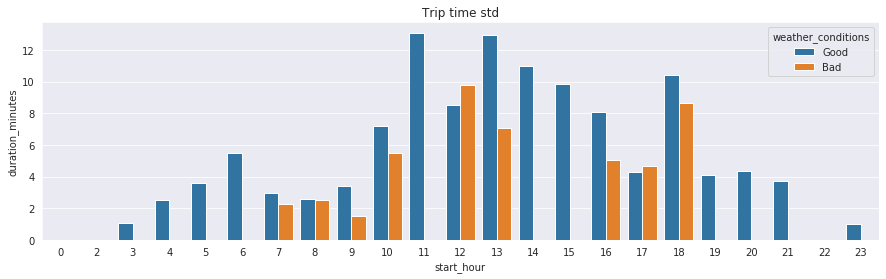

In [70]:
plt.figure(figsize=(15,4))
sns.barplot(x='start_hour',y='duration_minutes',data=df, hue='weather_conditions'
            ,ci=False
           ,estimator = np.std               
           )
plt.title('Trip time std')

We can see, that for some hours we don't have rainy trips at all

When we do have, in most cases average time of rainy trip is higher

Text(0.5, 0.98, 'Median trip time')

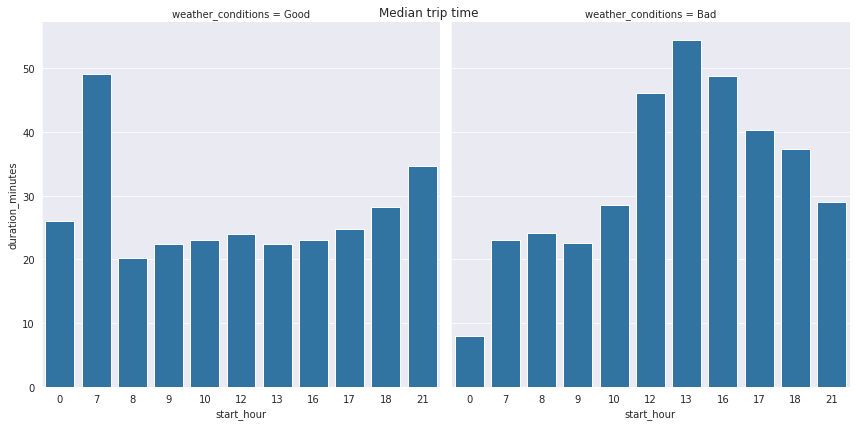

In [71]:
g = sns.FacetGrid(df, col="weather_conditions", height = 6)

g.map(sns.barplot, "start_hour","duration_minutes", ci=False,  order=None)


plt.suptitle("Median trip time") 


Here we can have good comparasion for the hours, that we have both kind of trips:

so at night from 0-6 am the average time is smaller, but around the day it is arising

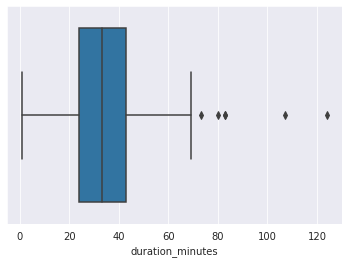

In [72]:
sns.boxplot(data = df,x= "duration_minutes"
            #, order=None
     )

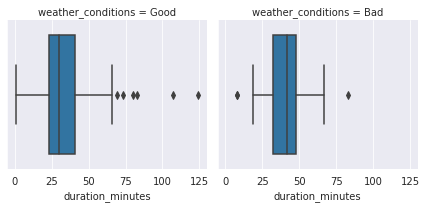

In [73]:
g = sns.FacetGrid(df, col="weather_conditions")
g.map(sns.boxplot,"duration_minutes", order=None);

That is why by calcultions rainy averagy duration is higher with smaller volatility

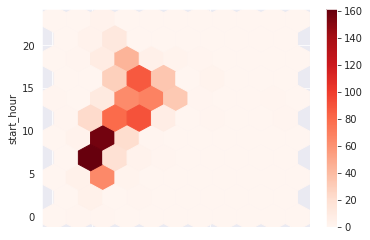

In [74]:
df.plot.hexbin(y='start_hour',x='duration_minutes'
               #,data=df
              #,kind='hex'
             , gridsize=10
              , cmap ='Reds')

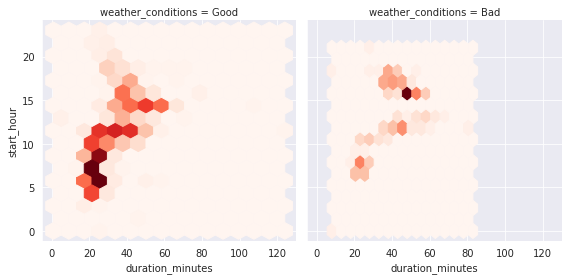

In [75]:
def hexbin(x, y, color, **kwargs):
    #cmap = sns.light_palette(color, as_cmap=True)
    cmap = 'Reds'
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

g = sns.FacetGrid(df, hue="weather_conditions", col="weather_conditions", height=4)
g.map(hexbin, "duration_minutes", "start_hour"
     # , extent=[0, 50, 0, 10]
     )

In general we can see, that rush hours are in the morning in the period from 6 to 10 am with duration 20-40 min.

When we dive deeper, we can see, that for sunny days it is about the same,

but for rainy days the "hot point" is 15 (3 pm) with duration more than 40 minutes.

### Hypothesis testing

"The average duration of rides from Loop neighborhood to O'Hare
International Airport changes on rainy Sundays."

I can formulate the Null Hypothesis, that:

The average duration of rides from Loop neighborhood to O'Hare International Airport on Sundays on rainy day equal to sunny day

In [76]:
alpha = .05

In [77]:
sample_good= df[df['weather_conditions']=='Good']['duration_minutes'].to_list()

In [78]:
sample_bad= df[df['weather_conditions']=='Bad']['duration_minutes'].to_list()

In [83]:
len(sample_good)
# len(sample_bad)

882

In [80]:
results = st.ttest_ind(sample_good, sample_bad, equal_var=False)

results

Ttest_indResult(statistic=-6.997007030892875, pvalue=2.1776489509755963e-11)

In [81]:
if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

We reject the null hypothesis


I can conclude with 95% confidence, that the average duration of rides is not the same

___
### Overall Conclusion:

1) At the moment, we have a situation on the market where top10 companies hold 72% of the market and capacity over 137 thousand rides. Among them, 'Flash Cab' is the leader with 14% of the market and about 20 thousand rides.

2) We have top10 popular dropoff locations that keep 77% of all trips. 'Loop'(19%) and 'River North' (17%) are leaders by the number of trips after them are 'Streeterville' (12%) and 'West Loop'(9%)

3) O'Hare int airport is only 5% of the market with about 2,5 thousand trips

4) For this period of the year proportion of days with good weather is very high, about 83%.

5) We have an interesting connection between the duration of the trip and the taxi order's time, for good weather we have more short trips. On the other hand, in Bad weather, we have fewer trips in general.

6) We can see that for some hours we don't have rainy trips at all. When we do have, in most cases, the average time of a rainy trip is higher. At night from 0-6 am, the average duration is shorter, but around the day, it is arising

7) Rush hours for sunny days are in the morning from 6 to 10 am with a duration 20-40 min. For rainy days the "hot point" is 15 (3 pm) with a duration of more than 40 minutes.

8) With 95% confidence, the average duration of rides from Loop neighborhood to O'Hare International Airport changes on rainy Sundays.


## Summary:
Weather is an essential factor in pair with the time of proceeding a ride, and on rainy days we have specific hours for the trip. And when we do have them, the average time is higher in general.

Also, commonly on rainy days, we have rides in the afternoon/evening time.

But the airport destination is only 5% of the market. Hence these results could not be significant if the company is not going to make this direction its specialization.